# Tarea 7

## Optimización I

### Esteban Reyes Saldaña

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# liberías
!cp drive/MyDrive/CIMAT/Segundo_Semestre/Optimización/T07/functions.py .

In [ ]:
import numpy as np
import time
import functions as func

Rosembrock      = func.Rosembrock
Rosembrock_Grad = func.Rosembrock_Grad
Rosembrock_Hess = func.Rosembrock_Hess

Wood            = func.Wood
Wood_Grad       = func.Wood_Grad
Wood_Hess       = func.Wood_Hess

Branin          = func.Branin
Branin_Grad     = func.Branin_Grad
Branin_Hess     = func.Branin_Hess

newton_modified      = func.newton_modified
get_newton_direction = func.get_newton_direction
get_graf             = func.get_graf

1. Implementa el método de Region de Confianza basado en Dogleg.


In [ ]:
def dogleg_step (g_k, b_k, delta_k) :
  '''
  Calcula el tamaño de paso de acuerdo a dogleg
  Parámetros 
  -----------
    g_k     : Gradiente de la función en la iteración k
    b_k     : Hessiano de la función en la itetación k
    delta_k : radio de tolerancia para región de confianza
  Regresa
  -----------
    p_k     : paso calculado por dogleg
  '''
  # Modelo cuadrático a lo largo del gradiente
  p_ku = - g_k.dot(g_k) / (g_k.dot(b_k).dot(g_k)) * g_k
  # Modelo cuadrático si b_k es positiva definida
  p_kb = - np.linalg.inv(b_k).dot(g_k)
  # p_kb está en el interior de la región de confianza
  if np.linalg.norm(p_kb) <= delta_k :
    p_k = p_kb
  # Intersección con la región de confianza con la trajectoria Dogleg
  elif np.linalg.norm(p_ku) >= delta_k :
    p_k =  delta_k * (p_ku / np.linalg.norm(p_ku))
  else :
    diff  = p_kb - p_ku
    a     = diff.dot(diff)
    b     = 2.0 * p_kb.dot(diff)
    c     = p_ku.dot(p_ku) - delta_k **2
    tau_k = 1.0 + (-b + np.sqrt(b**2 - 4.0 * a * c)) / (2.0 * a)
    # 1 <= tau <= 1
    if tau_k <= 1.0 :
      p_k = tau_k * p_ku
    # 1 < tau <=2
    else :
      p_k = p_ku + (tau_k - 1.0) * diff
  return p_k

In [ ]:
def trust_region( params = [], step = 'dogleg'):
  '''
  Calcula un mínimo dado una región de confianza
  Parámetros 
  -----------
  params : Diccionario de parámetros
    x_0      : punto inicial
    f        : función a evaluar
    f_grad   : regresa gradiente de f
    f_hess   : regresa hessiano de f
    max_iter : número maximo de iteraciones

    Trust-Region : Subparámetros del algoritmo región de confianza
      delta_k    : tamaño del radio de la región de confianza
      delta_max  : máxima tolerancia permitida
      eta        : tolerancia para métrica ro
      eta_min    : valor mínimo permitido [1/4, 3/4]
      eta1_hat   : parámetro de cambio eta_1 *delta_k
      eta_max    : valor máximo permitido [1/4, 3/4]
      eta2_hat   : parámetro de cambio  min(eta_2 * delta_k, delta_max)
  step   : método con el que se calcula el paso p_k
  
  Regresa 
  -----------
  f_hist : historial de cambios de f(x_k)
  g_hist : historial de norma del gradiente \nabla f(x_k)
  x_hist : historial de cambios de valores x_k
  '''
  # Cargo parámetros
  x_k         = params['x_0']
  f           = params['f']
  f_grad      = params['f_grad']
  f_hess      = params['f_hess']
  max_iter    = params['max_iter']
  tau_x       = params['tau_x']
  tau_f       = params['tau_f']
  tau_f_grad  = params['tau_grad']
  # Región de confianza
  delta_k     = params['Trust-Region']['delta_k']
  delta_max   = params['Trust-Region']['delta_max']
  eta         = params['Trust-Region']['eta']
  eta_min     = params['Trust-Region']['eta_min'] 
  eta_max     = params['Trust-Region']['eta_max']
  eta1_hat    = params['Trust-Region']['eta1_hat']
  eta2_hat      = params['Trust-Region']['eta2_hat']

  # Subpámetros para la función
  if f.__name__ == 'Branin' :
    sub_params = {
                  'a' : params['a'],
                  'b' : params['b'],
                  'c' : params['c'],
                  'r' : params['r'],
                  's' : params['s'],
                  't' : params['t']
                 }
  else :
    sub_params = {}
  # historial de valores
  f_hist = []
  g_hist = []
  x_hist = []
  # Valores de primera iteración
  f_k      = f(x_k, params = sub_params)
  g_k      = f_grad(x_k, params = sub_params)
  b_k      = f_hess(x_k, params = sub_params)
  # Primeros valores de historial
  f_hist.append(f_k)
  g_hist.append(np.linalg.norm(g_k))
  x_hist.append(x_k)

  # Comienza Método de Región de Confianza
  k = 0 
  while True:
    # Calculo paso de acuerdo a método seleccionado
    if step == 'dogleg' :
      p_k = dogleg_step(g_k, b_k, delta_k)
    elif step == 'cauchy' :
      p_k = cauchy_step(g_k, b_k, delta_k)
    elif step == 'newton-cauchy' :
      # Obtengo dirección de Newton
      p_k = get_newton_direction(g_k, b_k)
      # Tomo paso de Cauchy si paso de Newton está fuera de la region
      if np.linalg.norm(p_k) >= delta_k :
        p_k = cauchy_step(g_k, b_k, delta_k)
    else :
      print('paso no implementado.')
      return 
    # Calculo métrica ro para evaluar modelo
    m_kp = f_k + g_k.dot(p_k) + 0.5 * p_k.dot(b_k).dot(p_k)
    ro_k = (f_k - f(x_k + p_k, params = sub_params)) / (f_k - m_kp)
    # Actualizo radio de la región de confianza
    if ro_k < eta_min :
      delta_k = eta1_hat * delta_k
    elif  ro_k > eta_max and np.linalg.norm(p_k) == delta_k :
        delta_k = min(eta2_hat * delta_k, delta_max)
    # Actualizo valor del punto
    if ro_k > eta :
      x_k    = x_k + p_k
    # Calculo valores de f, gradiente y Hessiano
    f_k      = f(x_k, params = sub_params)
    g_k      = f_grad(x_k, params = sub_params)
    b_k      = f_hess(x_k, params = sub_params)
    # Guardo Parámetros
    x_hist.append(x_k)
    f_hist.append(f_k)
    g_hist.append(np.linalg.norm(g_k))
    # Actualizo contador
    k   = k + 1
    # Criterios de paro
    if k > max_iter :
      break
    if np.linalg.norm(g_k) < tau_f_grad :
      break  
    if np.linalg.norm(x_hist[-1] - x_hist[-2]) / max(np.linalg.norm(x_hist[-2]), 1.0) < tau_x :
      break
    if np.abs(f_hist[-1] - f_hist[-2]) / max(np.abs(f_hist[-2]), 1.0) < tau_f :
      break 
  return np.array(f_hist), np.array(g_hist), x_k

2. Implementa el metodo básico de "Region de Confianza" alterna entre el paso
de Newton y el Paso de Cauchy (le llamaremos Newton-Cauchy Alterno). Es decir, se toma el paso de Newton si esta en la región de confianza en otro caso se toma el Paso de Cauchy.

In [ ]:
def cauchy_step (g_k, b_k, delta_k) :
  # Resuelve problema lineal
  p_ks = - delta_k * g_k / np.linalg.norm(g_k)
 
  prod = g_k.dot(b_k).dot(g_k)
  if prod <= 0 :
    # Tomo el mayor valor posible
    tau_k = 1.0
  else :
    # Tomo tau en el interior
    tau_k = min(1.0, np.linalg.norm(g_k) ** 3 / (delta_k * prod))
  return tau_k * p_ks

3. Realice 30 corridas, de los algoritmos anteriores t del método de Newton Modificado aplicado a las funciones que aparecen abajo. Reporte los promedios
de tiempo de ejecución y número de iteraciones, segun aparece en las tablas
1 y 2. Seleccione los puntos iniciales de modo que cada entrada se obtenga
de la siguiente forma

$$ x_i^0 = x_i^* + \eta $$

donde $ x_i^* $ es la $i$-ésima entrada del óptimo $ x^* $ proporcionado más abajo para cada función y $ \eta \sim \mathcal{U}(-2,2). $

# Función de Rosembrock

## Corrida de prueba

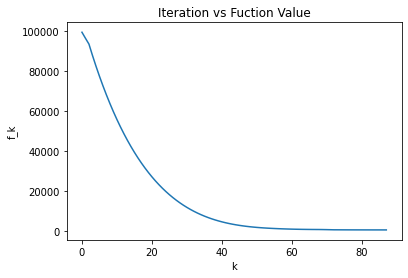

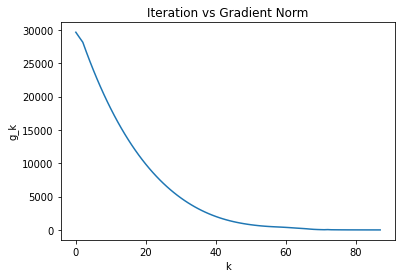

In [ ]:
n = 100
x_0 = [1.0 + np.random.uniform(-2,2) for i in range(n)]
x_0 = np.array(x_0)

params = {
          'x_0'      : x_0,
          'f'        : Rosembrock,
          'f_grad'   : Rosembrock_Grad,
          'f_hess'   : Rosembrock_Hess,
          'max_iter' : 1000,
          'tau_x'    : 1e-12,
          'tau_f'    : 1e-12,
          'tau_grad' : 1e-12,
          'Trust-Region' : {
                            'delta_k'   : 0.1,
                            'delta_max' : 0.2,
                            'eta'       : 0.1,
                            'eta_min'   : 0.25,
                            'eta_max'   : 0.75,
                            'eta1_hat'  : 0.25,
                            'eta2_hat'  : 2.0
                           }
          }

f_hist, g_hist, x = trust_region(params, step = 'dogleg')
get_graf(f_hist, g_hist)


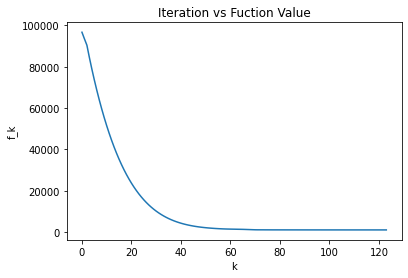

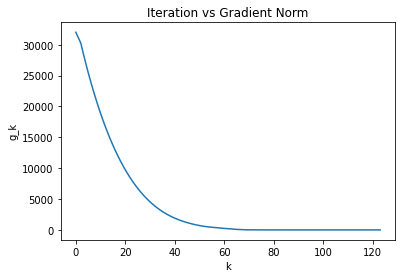

In [ ]:
n = 100
x_0 = [1.0 + np.random.uniform(-2,2) for i in range(n)]
x_0 = np.array(x_0)

params = {
          'x_0'      : x_0,
          'f'        : Rosembrock,
          'f_grad'   : Rosembrock_Grad,
          'f_hess'   : Rosembrock_Hess,
          'max_iter' : 1000,
          'tau_x'    : 1e-12,
          'tau_f'    : 1e-12,
          'tau_grad' : 1e-12,
          'Trust-Region' : {
                            'delta_k'   : 0.1,
                            'delta_max' : 0.2,
                            'eta'       : 0.1,
                            'eta_min'   : 0.25,
                            'eta_max'   : 0.75,
                            'eta1_hat'  : 0.25,
                            'eta2_hat'  : 2.0
                           }
          }

f_hist, g_hist, x = trust_region(params, step = 'newton-cauchy')
get_graf(f_hist, g_hist)

## 30 corridas

In [ ]:
iterations = 30
n = 100

time_dogleg                = []
iterations_dogleg          = []

time_newton_cauchy         = []
iterations_newton_cauchy   = []

time_newton_modified       = []
iterations_newton_modified = []

for i in range(iterations) :
  print('Corrida :', i+1)
  x_0 = [1.0 + np.random.uniform(-2,2) for i in range(n)]
  x_0 = np.array(x_0)

  params = {
          'x_0'      : x_0,
          'f'        : Rosembrock,
          'f_grad'   : Rosembrock_Grad,
          'f_hess'   : Rosembrock_Hess,
          'max_iter' : 1000,
          'tau_x'    : 1e-12,
          'tau_f'    : 1e-12,
          'tau_grad' : 1e-12,
          'Trust-Region' : {
                            'delta_k'   : 0.1,
                            'delta_max' : 0.2,
                            'eta'       : 0.1,
                            'eta_min'   : 0.25,
                            'eta_max'   : 0.75,
                            'eta1_hat'  : 0.25,
                            'eta2_hat'  : 2.0
                           }
          }
  # DOGLEG
  star              = time.time()
  f_hist, g_hist, x = trust_region(params, step = 'dogleg')
  # get_graf(f_hist, g_hist)
  ex_time           = time.time() - star  

  time_dogleg.append(ex_time)
  iterations_dogleg.append(f_hist.shape[0])

  # NEWTON-CAUCHY
  star              = time.time()
  f_hist, g_hist, x = trust_region(params, step = 'newton-cauchy')
  # get_graf(f_hist, g_hist)
  ex_time           = time.time() - star  

  time_newton_cauchy.append(ex_time)
  iterations_newton_cauchy.append(f_hist.shape[0])
  # Newton Modificado
  params = {
              'x_0'      : x_0,
              'f'        : Rosembrock,
              'f_grad'   : Rosembrock_Grad,
              'f_hess'   : Rosembrock_Hess,
              'max_iter' : 10000,
              'tau_x'    : 1e-12,
              'tau_f'    : 1e-12,
              'tau_grad' : 1e-12,
              'beta'     : 1e-12,
              'cholesky' : {
                            'max_iter' : 100
                            }
            }
  star                = time.time()
  f_hist, g_hist, x_k = newton_modified(params)
  ex_time             = time.time() - star  

  time_newton_modified.append(ex_time)
  iterations_newton_modified.append(f_hist.shape[0])

print('Dogleg:')
print('Tiempo promedio: ', np.mean(time_dogleg), ' Promedio de iteraciones : ', np.mean(iterations_dogleg))
print('Newton-Cauchy:')
print('Tiempo promedio: ', np.mean(time_newton_cauchy), ' Promedio de iteraciones : ', np.mean(iterations_newton_cauchy))
print('Newton Modificado:')
print('Tiempo promedio: ', np.mean(time_newton_modified), ' Promedio de iteraciones : ', np.mean(iterations_newton_modified))

Corrida : 1
Corrida : 2
Corrida : 3
Corrida : 4
Corrida : 5
Corrida : 6
Corrida : 7
Corrida : 8
Corrida : 9
Corrida : 10
Corrida : 11
Corrida : 12
Corrida : 13
Corrida : 14
Corrida : 15
Corrida : 16
Corrida : 17
Corrida : 18
Corrida : 19
Corrida : 20
Corrida : 21
Corrida : 22
Corrida : 23
Corrida : 24
Corrida : 25
Corrida : 26
Corrida : 27
Corrida : 28
Corrida : 29
Corrida : 30
Dogleg:
Tiempo promedio:  0.25037341912587485  Promedio de iteraciones :  89.5
Newton-Cauchy:
Tiempo promedio:  0.21546154816945393  Promedio de iteraciones :  83.53333333333333
Newton Modificado:
Tiempo promedio:  2.3138083378473917  Promedio de iteraciones :  447.0


# Función de Wood

## Corrida de prueba

[1.00000089 1.00000179 0.99999906 0.99999812]


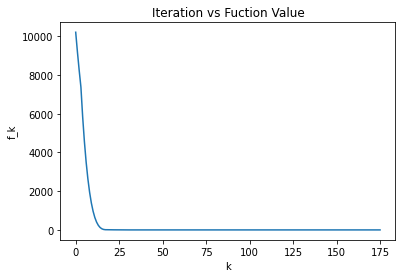

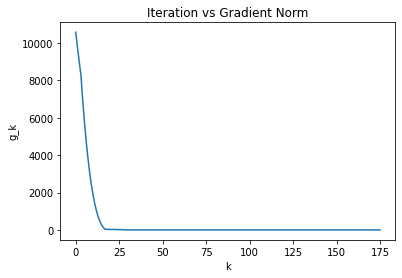

In [ ]:
n = 4
x_0 = [1.0 + np.random.uniform(-2,2) for i in range(n)]
x_0 = np.array(x_0)

params = {
          'x_0'      : x_0,
          'f'        : Wood,
          'f_grad'   : Wood_Grad,
          'f_hess'   : Wood_Hess,
          'max_iter' : 10000,
          'tau_x'    : 1e-12,
          'tau_f'    : 1e-12,
          'tau_grad' : 1e-12,
          'Trust-Region' : {
                            'delta_k'   : 0.1,
                            'delta_max' : 0.2,
                            'eta'       : 0.1,
                            'eta_min'   : 0.25,
                            'eta_max'   : 0.75,
                            'eta1_hat'  : 0.25,
                            'eta2_hat'  : 2.0
                           }
          }

f_hist, g_hist, x = trust_region(params, step = 'dogleg')
print(x)

get_graf(f_hist, g_hist)

[1.00000091 1.00000182 0.99999905 0.99999809]


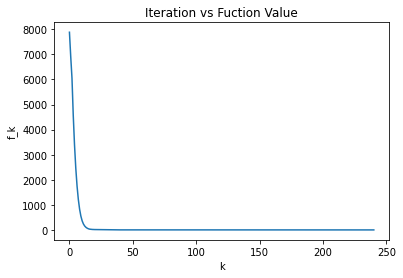

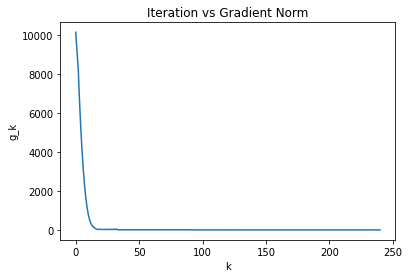

In [ ]:
n = 4
x_0 = [1.0 + np.random.uniform(-2,2) for i in range(n)]
x_0 = np.array(x_0)

params = {
          'x_0'      : x_0,
          'f'        : Wood,
          'f_grad'   : Wood_Grad,
          'f_hess'   : Wood_Hess,
          'max_iter' : 10000,
          'tau_x'    : 1e-12,
          'tau_f'    : 1e-12,
          'tau_grad' : 1e-12,
          'Trust-Region' : {
                            'delta_k'   : 0.1,
                            'delta_max' : 0.2,
                            'eta'       : 0.1,
                            'eta_min'   : 0.25,
                            'eta_max'   : 0.75,
                            'eta1_hat'  : 0.25,
                            'eta2_hat'  : 2.0
                           }
          }

f_hist, g_hist, x = trust_region(params, step = 'newton-cauchy')
print(x)

get_graf(f_hist, g_hist)

## 30 corridas

In [ ]:
iterations = 30
n = 4

time_dogleg              = []
iterations_dogleg        = []

time_newton_cauchy       = []
iterations_newton_cauchy = []


time_newton_modified       = []
iterations_newton_modified = []

for i in range(iterations) :
  print('Corrida :', i+1)
  x_0 = [1.0 + np.random.uniform(-2,2) for i in range(n)]
  x_0 = np.array(x_0)

  params = {
          'x_0'      : x_0,
          'f'        : Wood,
          'f_grad'   : Wood_Grad,
          'f_hess'   : Wood_Hess,
          'max_iter' : 1000,
          'tau_x'    : 1e-12,
          'tau_f'    : 1e-12,
          'tau_grad' : 1e-12,
          'Trust-Region' : {
                            'delta_k'   : 0.1,
                            'delta_max' : 0.2,
                            'eta'       : 0.1,
                            'eta_min'   : 0.25,
                            'eta_max'   : 0.75,
                            'eta1_hat'  : 0.25,
                            'eta2_hat'  : 2.0
                           }
          }
  # DOGLEG
  star              = time.time()
  f_hist, g_hist, x = trust_region(params, step = 'dogleg')
  print('Dogleg        x* :', x)

  # get_graf(f_hist, g_hist)
  ex_time           = time.time() - star  

  time_dogleg.append(ex_time)
  iterations_dogleg.append(f_hist.shape[0])

  # NEWTON-CAUCHY
  star              = time.time()
  f_hist, g_hist, x = trust_region(params, step = 'newton-cauchy')
  print('Newton-Cauchy x* :', x)
  # get_graf(f_hist, g_hist)
  ex_time           = time.time() - star  

  time_newton_cauchy.append(ex_time)
  iterations_newton_cauchy.append(f_hist.shape[0])

  # Newton Modificado
  params = {
              'x_0'      : x_0,
              'f'        : Wood,
              'f_grad'   : Wood_Grad,
              'f_hess'   : Wood_Hess,
              'max_iter' : 10000,
              'tau_x'    : 1e-12,
              'tau_f'    : 1e-12,
              'tau_grad' : 1e-12,
              'beta'     : 1e-12,
              'cholesky' : {
                            'max_iter' : 100
                            }
            }
  star                = time.time()
  f_hist, g_hist, x = newton_modified(params)
  ex_time             = time.time() - star  
  print('Newton Modifi x* :', x)

  time_newton_modified.append(ex_time)
  iterations_newton_modified.append(f_hist.shape[0])

print('Dogleg:')
print('Tiempo promedio: ', np.mean(time_dogleg), ' Promedio de iteraciones : ', np.mean(iterations_dogleg))
print('Newton-Cauchy:')
print('Tiempo promedio: ', np.mean(time_newton_cauchy), ' Promedio de iteraciones : ', np.mean(iterations_newton_cauchy))
print('Newton Modificado:')
print('Tiempo promedio: ', np.mean(time_newton_modified), ' Promedio de iteraciones : ', np.mean(iterations_newton_modified))

Corrida : 1
Dogleg        x* : [1.00000092 1.00000185 0.99999904 0.99999807]
Newton-Cauchy x* : [1.00000094 1.00000188 0.99999902 0.99999804]
Newton Modifi x* : [0.99999908 0.99999815 1.00000096 1.00000193]
Corrida : 2
Dogleg        x* : [0.99999911 0.99999821 1.00000094 1.00000188]
Newton-Cauchy x* : [0.51479274 0.2651842  1.28511569 1.6541088 ]
Newton Modifi x* : [1.00000092 1.00000184 0.99999904 0.99999808]
Corrida : 3
Dogleg        x* : [ 1.28019871  1.63323751 -0.43430821  0.2087043 ]
Newton-Cauchy x* : [ 1.20968681  1.46645518 -0.66287649  0.45204281]
Newton Modifi x* : [1.00000094 1.00000188 0.99999902 0.99999803]
Corrida : 4
Dogleg        x* : [1.00000094 1.00000188 0.99999902 0.99999804]
Newton-Cauchy x* : [1.00000091 1.00000183 0.99999905 0.99999809]
Newton Modifi x* : [1.00000089 1.00000178 0.99999907 0.99999814]
Corrida : 5
Dogleg        x* : [1.00000093 1.00000186 0.99999903 0.99999806]
Newton-Cauchy x* : [1.00000088 1.00000177 0.99999908 0.99999815]
Newton Modifi x* : [0.

# Función de Branin

## Corrida de prueba

[3.14159239 2.27500021]


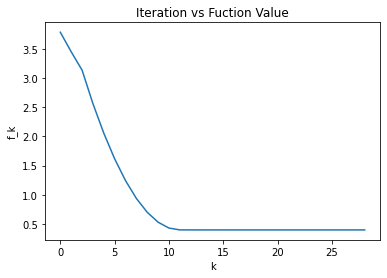

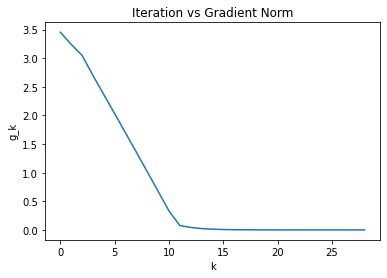

In [ ]:
x_0 = [np.pi + np.random.uniform(-2,2), 2.275 + np.random.uniform(-2,2)]
x_0 = np.array(x_0)

params = {
          'x_0'      : x_0,
          'f'        : Branin,
          'f_grad'   : Branin_Grad,
          'f_hess'   : Branin_Hess,
          'max_iter' : 10000,
          'tau_x'    : 1e-12,
          'tau_f'    : 1e-12,
          'tau_grad' : 1e-12,
          'a' : 1.0,
          'b' : 5.1 / (4.0 * np.pi**2),
          'c' : 5.0 / np.pi,
          'r' : 6.0,
          's' : 10.0,
          't' : 1.0 / (8.0 * np.pi),
          'Trust-Region' : {
                            'delta_k'   : 0.1,
                            'delta_max' : 0.2,
                            'eta'       : 0.1,
                            'eta_min'   : 0.25,
                            'eta_max'   : 0.75,
                            'eta1_hat'  : 0.25,
                            'eta2_hat'  : 2.0
                           }
          }

f_hist, g_hist, x = trust_region(params, step = 'dogleg')
print(x)

get_graf(f_hist, g_hist)

[3.14159291 2.2749998 ]


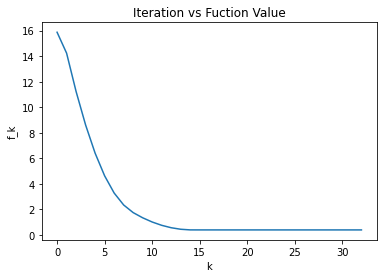

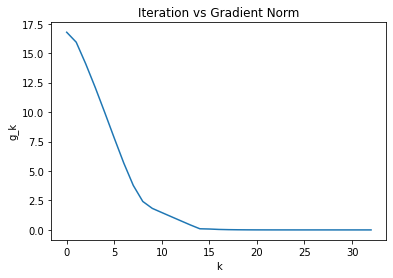

In [ ]:
x_0 = [np.pi + np.random.uniform(-2,2), 2.275 + np.random.uniform(-2,2)]
x_0 = np.array(x_0)

params = {
          'x_0'      : x_0,
          'f'        : Branin,
          'f_grad'   : Branin_Grad,
          'f_hess'   : Branin_Hess,
          'max_iter' : 10000,
          'tau_x'    : 1e-12,
          'tau_f'    : 1e-12,
          'tau_grad' : 1e-12,
          'a' : 1.0,
          'b' : 5.1 / (4.0 * np.pi**2),
          'c' : 5.0 / np.pi,
          'r' : 6.0,
          's' : 10.0,
          't' : 1.0 / (8.0 * np.pi),
          'Trust-Region' : {
                            'delta_k'   : 0.1,
                            'delta_max' : 0.2,
                            'eta'       : 0.1,
                            'eta_min'   : 0.25,
                            'eta_max'   : 0.75,
                            'eta1_hat'  : 0.25,
                            'eta2_hat'  : 2.0
                           }
          }

f_hist, g_hist, x = trust_region(params, step = 'newton-cauchy')
print(x)

get_graf(f_hist, g_hist)

## 30 corridas

In [ ]:
iterations = 30
n = 4

time_dogleg                = []
iterations_dogleg          = []

time_newton_cauchy         = []
iterations_newton_cauchy   = []

time_newton_modified       = []
iterations_newton_modified = []

for i in range(iterations) :
  print('Corrida :', i+1)
  x_0 = [np.pi + np.random.uniform(-2,2), 2.275 + np.random.uniform(-2,2)]
  x_0 = np.array(x_0)

  params = {
          'x_0'      : x_0,
          'f'        : Branin,
          'f_grad'   : Branin_Grad,
          'f_hess'   : Branin_Hess,
          'max_iter' : 10000,
          'tau_x'    : 1e-12,
          'tau_f'    : 1e-12,
          'tau_grad' : 1e-12,
          'a' : 1.0,
          'b' : 5.1 / (4.0 * np.pi**2),
          'c' : 5.0 / np.pi,
          'r' : 6.0,
          's' : 10.0,
          't' : 1.0 / (8.0 * np.pi),
          'Trust-Region' : {
                            'delta_k'   : 0.1,
                            'delta_max' : 0.2,
                            'eta'       : 0.1,
                            'eta_min'   : 0.25,
                            'eta_max'   : 0.75,
                            'eta1_hat'  : 0.25,
                            'eta2_hat'  : 2.0
                           }
          }
  # DOGLEG
  star              = time.time()
  f_hist, g_hist, x = trust_region(params, step = 'dogleg')
  print('Dogleg        x* :', x)

  # get_graf(f_hist, g_hist)
  ex_time           = time.time() - star  

  time_dogleg.append(ex_time)
  iterations_dogleg.append(f_hist.shape[0])

  # NEWTON-CAUCHY
  star              = time.time()
  f_hist, g_hist, x = trust_region(params, step = 'newton-cauchy')
  print('Newton-Cauchy x* :', x)

  # get_graf(f_hist, g_hist)
  ex_time           = time.time() - star  

  time_newton_cauchy.append(ex_time)
  iterations_newton_cauchy.append(f_hist.shape[0])
  # Newton Modificado
  params = {
          'x_0'      : x_0,
          'f'        : Branin,
          'f_grad'   : Branin_Grad,
          'f_hess'   : Branin_Hess,
          'max_iter' : 10000,
          'tau_x'    : 1e-12,
          'tau_f'    : 1e-12,
          'tau_grad' : 1e-12,
          'beta'     : 1e-12,
          'a' : 1.0,
          'b' : 5.1 / (4.0 * np.pi**2),
          'c' : 5.0 / np.pi,
          'r' : 6.0,
          's' : 10.0,
          't' : 1.0 / (8.0 * np.pi),
              'cholesky' : {
                            'max_iter' : 100
                            }
            }
  star                = time.time()
  f_hist, g_hist, x = newton_modified(params)
  ex_time             = time.time() - star  
  print('Newton Modifi x* :', x)

  time_newton_modified.append(ex_time)
  iterations_newton_modified.append(f_hist.shape[0])

print('Dogleg:')
print('Tiempo promedio: ', np.mean(time_dogleg), ' Promedio de iteraciones : ', np.mean(iterations_dogleg))
print('Newton-Cauchy:')
print('Tiempo promedio: ', np.mean(time_newton_cauchy), ' Promedio de iteraciones : ', np.mean(iterations_newton_cauchy))
print('Newton Modificado:')
print('Tiempo promedio: ', np.mean(time_newton_modified), ' Promedio de iteraciones : ', np.mean(iterations_newton_modified))

Corrida : 1
Dogleg        x* : [3.14159287 2.27499983]
Newton-Cauchy x* : [3.14159287 2.27499983]
Newton Modifi x* : [3.14159243 2.27500018]
Corrida : 2
Dogleg        x* : [3.14159289 2.27499982]
Newton-Cauchy x* : [3.14159248 2.27500014]
Newton Modifi x* : [3.14159283 2.27499986]
Corrida : 3
Dogleg        x* : [6.36999887 1.08092289]
Newton-Cauchy x* : [3.14159283 2.27499986]
Newton Modifi x* : [3.14159289 2.27499982]
Corrida : 4
Dogleg        x* : [3.14159246 2.27500015]
Newton-Cauchy x* : [3.14159246 2.27500015]
Newton Modifi x* : [3.14159247 2.27500014]
Corrida : 5
Dogleg        x* : [3.14159244 2.27500017]
Newton-Cauchy x* : [3.14159246 2.27500015]
Newton Modifi x* : [3.1415924 2.2750002]
Corrida : 6
Dogleg        x* : [3.14159289 2.27499981]
Newton-Cauchy x* : [3.14159292 2.27499979]
Newton Modifi x* : [3.14159293 2.27499979]
Corrida : 7
Dogleg        x* : [6.25293281 1.09850912]
Newton-Cauchy x* : [3.14159282 2.27499987]
Newton Modifi x* : [3.14159241 2.27500019]
Corrida : 8
Dog